# Bao et al (2018) Magnetic Susceptibility

This notebook presents reanalysis of the data and cyclostratigraphy presented by Bao et al., (2018).

> Bao, X., Zhang, S., Jiang, G., Wu, H., Li, H., Wang, X., An, Z., and Yang, T., 2018, Cyclostratigraphic constraints on the duration of the Datangpo Formation and the onset age of the Nantuo (Marinoan) glaciation in South China: Earth and Planetary Science Letters, v. 483, p. 52–63, doi:10.1016/j.epsl.2017.12.001.

Bao et al., (2018) take obliquity and precession durations to be 28-30 kyr and 15-20 kyr:

“The precession constant (k) of the Marinoan-aged period is thus estimated as 62.03–64.60′′/yr (Williams, 2000; Table 1) and the major periods of obliquity and precession were estimated as 30–28 kyr and 20–15 kyr, respectively.” ([Bao et al., 2018, p. 60](zotero://select/library/items/92WY5AUR)) ([pdf](zotero://open-pdf/library/items/68UYDB35?page=9&annotation=3XFNG373))

*Note*: This notebook makes use of the [spectral](https://github.com/sarttiso/spectral) python package, which is not yet available via pip or conda.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import numpy as np
from scipy import signal, ndimage
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm

import spectral

In [2]:
ms = pd.read_csv('Bao_et_al_2018_MS_data.csv')

Interpolate to ensure 1 cm spacing.

In [3]:
dx0 = 0.01

depth = ms['depth'].values
height = (-depth)-np.min(-depth)

# sort by height
idx_sort = np.argsort(height)
height = height[idx_sort]

# interpolate onto consistent x axis which is height (younging coordinate)
x = np.arange(np.min(height), 
              np.max(height) + dx0,
              dx0)
y = np.interp(x, height, ms.iloc[idx_sort]['MS (e-6 SI)'].values)

# have corresponding depth coordinate
x_depth = np.flipud(np.arange(np.min(depth), 
              np.max(depth) + dx0,
              dx0))

This (re)analysis will focus on unit 4, the thickest portion of the core.

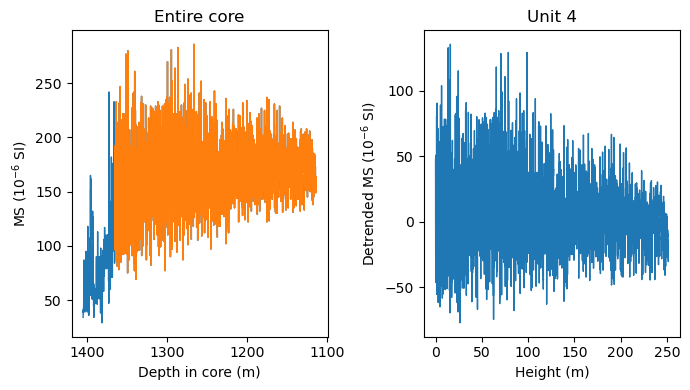

In [4]:
idx = x_depth < 1365 # Unit 4
n_spec = np.sum(idx)

x_4 = x[idx] - np.min(x[idx])
x_4_depth = x_depth[idx]
# y_4 = y[idx] - np.mean(y[idx])
y_4 = signal.detrend(y[idx])
# y_4 = np.append(np.diff(y[idx]), np.mean(np.diff(y[idx])))

fig, ax = plt.subplots(1, 2, figsize=(7,4))

ax[0].plot(x_depth, y, linewidth=1)
ax[0].plot(x_depth[idx], y[idx], linewidth=1)
ax[0].set_xlabel('Depth in core (m)')
ax[0].set_ylabel('MS (10$^{-6}$ SI)')
ax[0].set_title('Entire core')
ax[0].invert_xaxis()

ax[1].plot(x_4, y_4, linewidth=1)
ax[1].set_xlabel('Height (m)')
ax[1].set_ylabel('Detrended MS (10$^{-6}$ SI)')
ax[1].set_title('Unit 4')

plt.tight_layout()

# plt.savefig('figures/depth_series_unit4.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

### MT PSD

PSD for all of Unit 4.

In [86]:
dx_dec = 0.08
dx_filt = 2*dx_dec
fs_filt_low = 0.01

sos = signal.butter(8, [fs_filt_low, 1/dx_filt], btype='bandpass', fs=1/dx0, output='sos')
# sos = signal.butter(4, 1/2/dx, btype='lowpass', fs=1/dx0, output='sos')

# y_4_filt = signal.lfilter(b, a, y_4)
y_4_filt = signal.sosfilt(sos, y_4)

y_4_filt_dec = y_4_filt[slice(0, len(ms), int(dx_dec/dx0))]
y_4_filt_dec = signal.detrend(y_4_filt_dec)
x_4_filt_dec = x_4[slice(0, len(ms), int(dx_dec/dx0))]

# y_4_filt = y_4[slice(0, len(ms), int(dx/dx0))]
# x_4_filt = x_4[slice(0, len(ms), int(dx/dx0))]

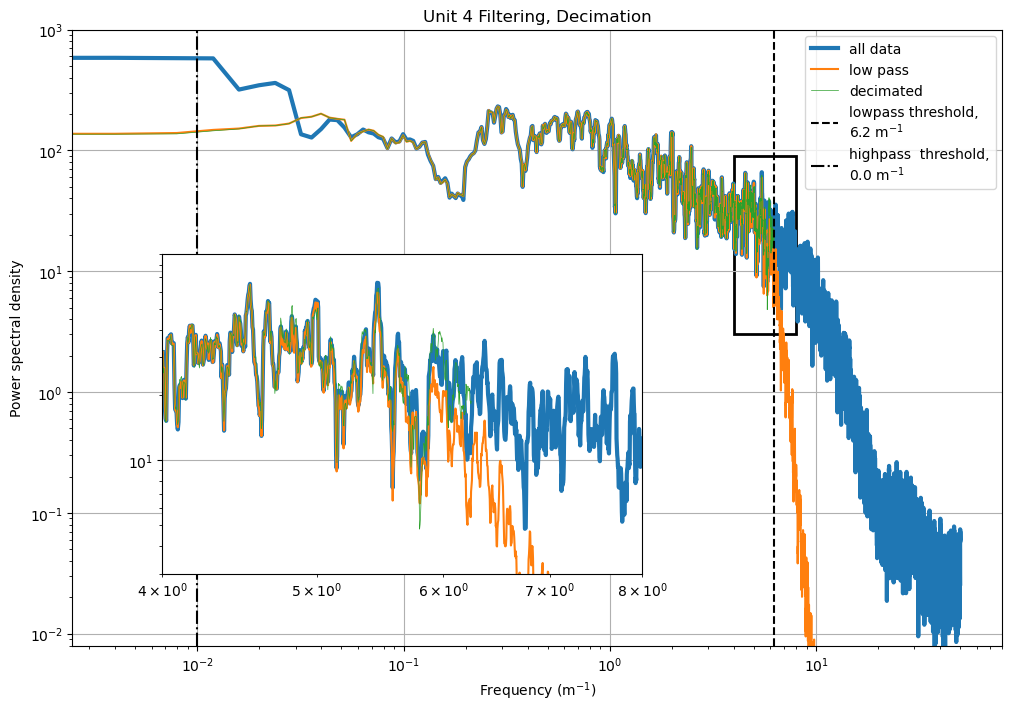

In [114]:
S_est, f = spectral.multitaper(y_4, dx0, nw=6)
S_est_filt, f_filt = spectral.multitaper(y_4_filt, dx0, nw=6)
S_est_filt_dec, f_filt_dec = spectral.multitaper(y_4_filt_dec, dx_dec, nw=6)

fig = plt.figure(figsize=(12, 8))
ax1 = plt.axes()

ax1.loglog(f, S_est, linewidth=3, label='all data')
ax1.loglog(f_filt, S_est_filt, linewidth=1.5, label='low pass')
ax1.loglog(f_filt_dec, S_est_filt_dec, linewidth=0.5, linestyle='-', label='decimated')


cutoff_dec = 1/dx_dec
cutoff_low = 1/dx_filt
cutoff_high = fs_filt_low

ax1.axvline(cutoff_low, color='k', linestyle='--', label=f'lowpass threshold,\n{cutoff_low:1.1f} m$^{{-1}}$')
ax1.axvline(cutoff_high, color='k', linestyle='-.', label=f'highpass  threshold,\n{cutoff_high:1.1f} m$^{{-1}}$')

ax1.set_xlabel('Frequency (m$^{-1}$)')
ax1.set_ylabel('Power spectral density')

ax1.set_title('Unit 4 Filtering, Decimation')

ax1.set_ylim([8e-3, 1e3])
ax1.grid()
ax1.legend(loc='upper right')

# inset
ax2 = plt.axes([0.2, 0.2, 0.4, 0.4])
# ax2_xmin = 8
# ax2_xmax = 12
# ax2_ymin = 0.8
# ax2_ymax = 20
ax2_xmin = 4
ax2_xmax = 8
ax2_ymin = 3
ax2_ymax = 90
idx = (f > ax2_xmin) & (f < ax2_xmax)
ax2.loglog(f[idx], S_est[idx], linewidth=3, label='all data')
idx = (f_filt > ax2_xmin) & (f_filt < ax2_xmax)
ax2.loglog(f_filt[idx], S_est_filt[idx], linewidth=1.5, label='low pass')
idx = (f_filt_dec > ax2_xmin) & (f_filt_dec < ax2_xmax)
ax2.loglog(f_filt_dec[idx], S_est_filt_dec[idx], linewidth=0.5, linestyle='-', label='decimated')
ax2.set_ylim([ax2_ymin, ax2_ymax])
ax2.set_xlim([ax2_xmin, ax2_xmax])
ax2.grid()

rect = Rectangle((ax2_xmin, ax2_ymin), ax2_xmax-ax2_xmin, ax2_ymax-ax2_ymin, fill=False, edgecolor='k', linewidth=2)
ax1.add_patch(rect)

plt.savefig('figures/filtering_decimation_unit4_psd.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

Filter out high frequencies (low power anyway, just don't want aliasing).

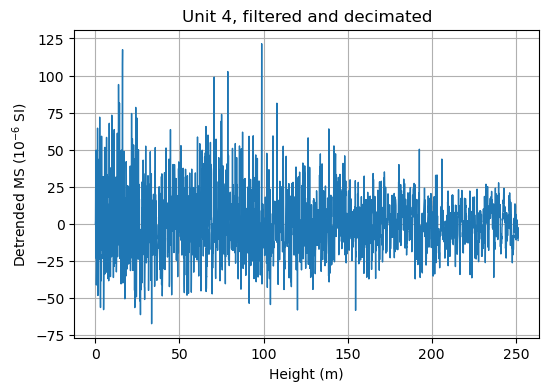

In [115]:
fig = plt.figure(figsize=(6,4))

plt.plot(x_4_filt_dec, y_4_filt_dec, linewidth=1)
plt.title('Unit 4, filtered and decimated')
plt.xlabel('Height (m)')
plt.ylabel('Detrended MS (10$^{-6}$ SI)')
plt.grid()

plt.savefig('figures/unit4_filtered_decimated_series.pdf', format='pdf', bbox_inches='tight')

plt.show()

## ARIMA modeling

In [395]:
bao_fit = pm.auto_arima(y_4_filt_dec, start_p=0, start_q=0,
                         max_p=15, max_q=15, seasonal=False,
                         d=None, trace=True,
                         error_action='ignore',  # don't want to know if an order does not work
                         suppress_warnings=True,  # don't want convergence warnings
                         stepwise=False, method='lbfgs', njobs=-1)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27581.049, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=27079.183, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=27017.763, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=26983.432, Time=0.34 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=26985.421, Time=0.26 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=26984.526, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26988.457, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26988.928, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=26990.830, Time=0.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=26985.404, Time=0.61 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=26987.262, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26988.996, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=26990.903, Time=0.64 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=26987.984, Time=0.57 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=26985.816, Time=0.87

In [396]:
d = 0
arima_model = SARIMAX(y_4_filt_dec, order=(0, d, 3))
bao_fit = arima_model.fit()

In [397]:
bao_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3143
Model:               SARIMAX(0, 0, 3)   Log Likelihood              -13487.716
Date:                Wed, 06 Dec 2023   AIC                          26983.432
Time:                        15:38:23   BIC                          27007.643
Sample:                             0   HQIC                         26992.120
                               - 3143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4084      0.012     32.948      0.000       0.384       0.433
ma.L2          0.1786      0.014     12.898      0.000       0.151       0.206
ma.L3          0.1063      0.016      6.813      0.000       0.076       0.137
sigma2       312.5520      5.087     61.445      0.000     302.582     322.522
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1199.03
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [398]:
ljungbox_p = spectral.LjungBox_p(bao_fit.resid, 3)
print(ljungbox_p)

0.12682447869485258


In [399]:
phi = bao_fit.arparams.reshape(-1, 1)
theta = bao_fit.maparams.reshape(-1, 1)
sig2 = bao_fit.params[-1]

p = len(phi)
q = len(theta)

In [400]:
nw = 6

S_est, f = spectral.multitaper(np.diff(y_4_filt_dec, d), dx_dec, nw=nw)
S_est_res, f_res = spectral.multitaper(bao_fit.resid, dx_dec, nw=nw)

# p = 2
# phi, sig2 = spectral.yulewalker(y_4, p)

# from scipy.signal import windows
N = n_spec
w = nw/N
K = int(2 * nw - 1)
# wins = windows.dpss(N, nw, Kmax=K)

# fac = (np.sum(wins**4) / (K**2)) * N

C:\Users\XPS\miniconda3\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


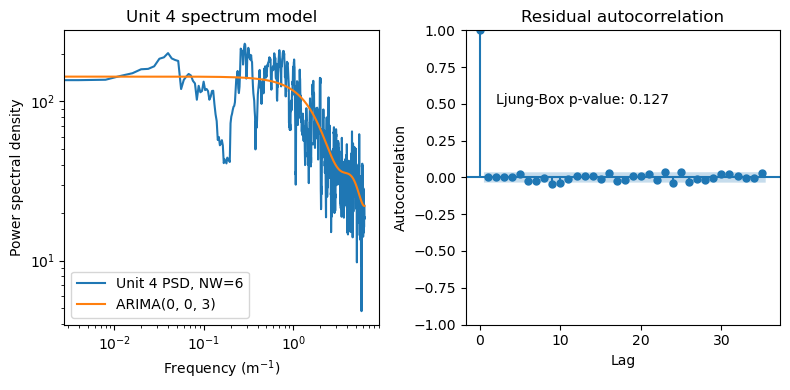

In [401]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].loglog(f, S_est, label=f'Unit 4 PSD, NW={nw}')
ax[0].loglog(f, 2*spectral.ARMA_psd(f, phi, theta, sig2, dt=dx_dec), label=f'ARIMA({p}, {d}, {q})')
ax[0].legend()
ax[0].set_xlabel('Frequency (m$^{-1}$)')
ax[0].set_ylabel('Power spectral density')
ax[0].set_title('Unit 4 spectrum model')

_ = pm.plot_acf(bao_fit.resid, ax=ax[1], alpha=0.05, title='Residual autocorrelation', show=False)
ax[1].text(2, 0.5, f'Ljung-Box p-value: {ljungbox_p:1.3f}')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')

plt.tight_layout()

plt.savefig('figures/unit4_spectrum_model.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

## Spectrogram

In [402]:
win = int(50/dx_dec)
noverlap = win-1
nw = 10

S_est, f, h = spectral.multitaper_spectrogram(bao_fit.resid, dx_dec, win,
                                              nw=nw, noverlap=noverlap, 
                                              include_last=False)

100%|█████████████████████████████████████████████████████████████████████████████| 2519/2519 [00:16<00:00, 148.24it/s]


Evaluate significance of peaks for each window.

In [403]:
y_windowed, t = spectral.window_series(bao_fit.resid, win, noverlap=noverlap, dt=dx_dec)

# 1 if significant, 0 if not
S_est_sig = []
F_stat = []
for ii in tqdm(range(y_windowed.shape[0])):
    cur_F_stat, f_sig, levels = spectral.f_test_thom(y_windowed[ii, :], dx_dec, nw, confs=[1-1/win])
    F_stat.append(cur_F_stat)
    S_est_sig.append(cur_F_stat > levels[0])

S_est_sig = np.array(S_est_sig)
F_stat = np.array(F_stat)

  0%|          | 0/2519 [00:00<?, ?it/s]

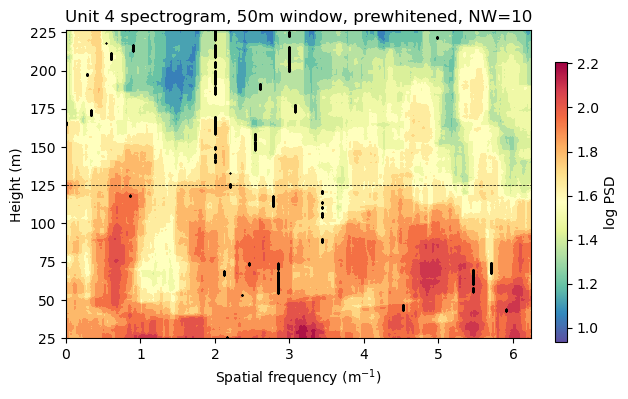

In [425]:
period_labels = np.array([0.125, 0.25, 0.5, 1, 2, 3, 4, 5, 7])

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()

# interpolate and plot PSD
zoom = 3
S_est_int_log = ndimage.zoom(np.log10(S_est+2), zoom)
# S_est_int_log = ndimage.zoom(S_est + 50, zoom)
ax.contourf(ndimage.zoom(f, zoom), ndimage.zoom(h, zoom), S_est_int_log, levels=20, cmap='Spectral_r')

# plot significance indicators
for ii in range(S_est_sig.shape[0]):
    idx = S_est_sig[ii] == True
    plt.plot(f_sig[idx], np.sum(idx)*[h[ii]], 'kx', markersize=1)

# ax.set_xscale('log')
# ax.set_xlim([0, 6])
# ax.set_xticks([1/x for x in period_labels])
# ax.set_xticklabels(period_labels)

# ax.axvline(3)

ax.axhline(125, color='k', linestyle='--', linewidth=0.5)

ax.set_xlabel('Spatial frequency (m$^{-1}$)')
ax.set_ylabel('Height (m)')
ax.set_title(f'Unit 4 spectrogram, {win*dx_dec:1.0f}m window, prewhitened, NW={nw}')

# ax.set_xlim([np.min(1/period_labels), np.max(1/period_labels)])

cax = plt.axes((0.94, 0.1, 0.02, 0.7))
norm = mpl.colors.Normalize(vmin=np.min(S_est_int_log.reshape(-1)), 
                            vmax=np.max(S_est_int_log.reshape(-1)))
fig.colorbar(mpl.cm.ScalarMappable(norm, cmap='Spectral_r'), 
             cax=cax, orientation='vertical', label='log PSD')

# plt.savefig('figures/unit4_spectrogram.pdf', format='pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figures/unit4_spectrogram.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

## Lower Unit 4

In [356]:
threshold_1 = 125
idx = (x_4_filt_dec < threshold_1)

n_spec = np.sum(idx)

x_4_lower = x_4_filt_dec[idx]
y_4_lower = signal.detrend(y_4_filt_dec[idx])

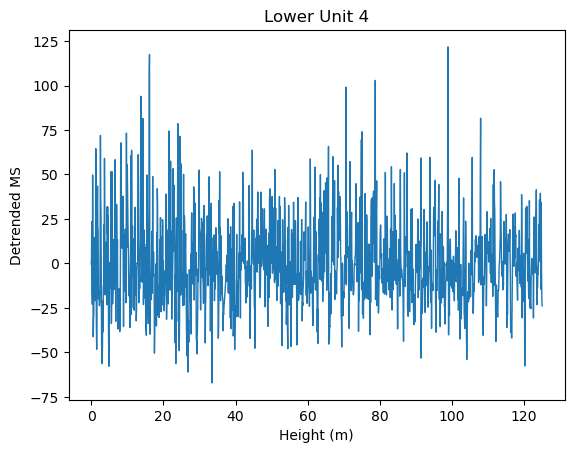

In [357]:
plt.plot(x_4_lower, y_4_lower, linewidth=1)

plt.xlabel('Height (m)')
plt.ylabel('Detrended MS')
plt.title('Lower Unit 4')

plt.show()

In [358]:
bao_fit = pm.auto_arima(y_4_lower, start_p=0, start_q=0,
                         max_p=15, max_q=15, seasonal=False,
                         d=None, trace=True,
                         error_action='ignore',  # don't want to know if an order does not work
                         suppress_warnings=True,  # don't want convergence warnings
                         stepwise=True, method='lbfgs', njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14327.661, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14080.215, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14110.298, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14082.199, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14082.200, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14084.208, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14082.215, Time=0.12 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.665 seconds


In [359]:
d = 0
arima_model = SARIMAX(y_4_lower, order=(1, d, 0))
bao_fit = arima_model.fit()

In [360]:
bao_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1563
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7038.108
Date:                Wed, 06 Dec 2023   AIC                          14080.215
Time:                        15:11:28   BIC                          14090.924
Sample:                             0   HQIC                         14084.196
                               - 1563                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3840      0.019     20.602      0.000       0.347       0.421
sigma2       477.4823     12.926     36.939      0.000     452.147     502.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               248.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [361]:
ljungbox_p = spectral.LjungBox_p(bao_fit.resid, 3)
print(ljungbox_p)

0.08428903090793227


In [362]:
phi = bao_fit.arparams.reshape(-1, 1)
theta = bao_fit.maparams.reshape(-1, 1)
sig2 = bao_fit.params[-1]

p = len(phi)
q = len(theta)

In [363]:
nw = 12

S_est, f = spectral.multitaper(np.diff(y_4_lower, d), dx_dec, nw=nw)
S_est_res, f_res = spectral.multitaper(bao_fit.resid, dx_dec, nw=nw)

N = n_spec
w = nw/N
K = int(2 * nw - 1)

C:\Users\XPS\miniconda3\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


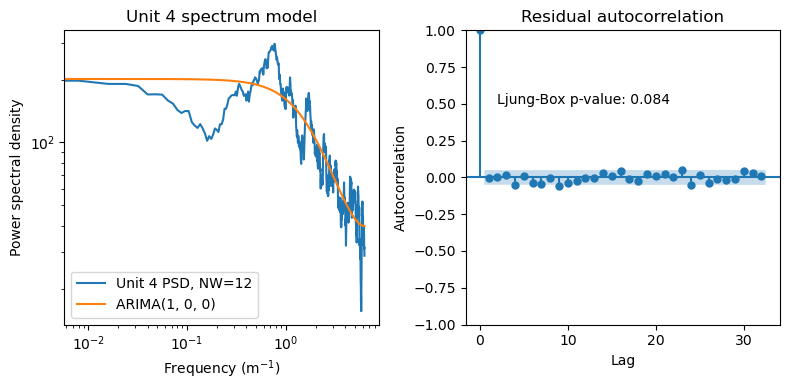

In [364]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].loglog(f, S_est, label=f'Unit 4 PSD, NW={nw}')
ax[0].loglog(f, 2*spectral.ARMA_psd(f, phi, theta, sig2, dt=dx_dec), label=f'ARIMA({p}, {d}, {q})')
ax[0].legend()
ax[0].set_xlabel('Frequency (m$^{-1}$)')
ax[0].set_ylabel('Power spectral density')
ax[0].set_title('Unit 4 spectrum model')

_ = pm.plot_acf(bao_fit.resid, ax=ax[1], alpha=0.05, title='Residual autocorrelation', show=False)
ax[1].text(2, 0.5, f'Ljung-Box p-value: {ljungbox_p:1.3f}')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')

plt.tight_layout()

# plt.savefig('figures/unit4_lower_spectrum_model.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [365]:
period_labels = [0.25, 0.5, 1, 2, 3, 4, 5, 10, 50]

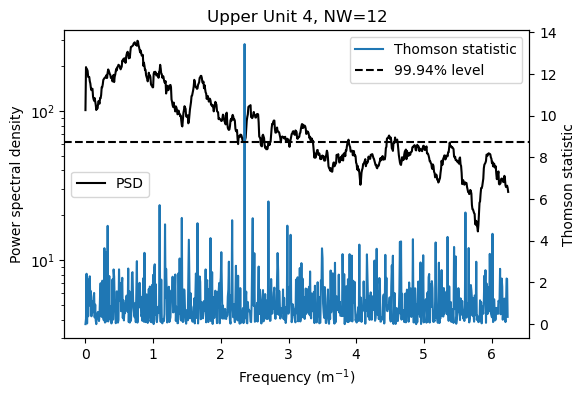

In [373]:
confs = [1-1/len(y_4_lower)]
F_stat, f_sig, levels = spectral.f_test_thom(y_4_lower, dx_dec, nw, confs=confs)

fig = plt.figure(figsize=(6,4))

ax1 = plt.axes()
ax1.semilogy(f, S_est, 'k-', label='PSD')
ax1.set_ylim([3, 350])
ax1.set_ylabel('Power spectral density')
ax1.set_xlabel('Frequency (m$^{-1}$)')
ax1.set_title(f'Upper Unit 4, NW={nw}')
ax1.legend(loc='center left')

ax2 = ax1.twinx()
ax2.plot(f_sig, F_stat, label='Thomson statistic')
for conf in confs:
    ax2.axhline(levels, color='k', linestyle='--', label=f'{100*conf:1.2f}% level')
ax2.set_ylabel('Thomson statistic')
ax2.legend()

plt.savefig('figures/lower_unit4_psd.pdf', format='pdf', bbox_inches='tight')

plt.show()

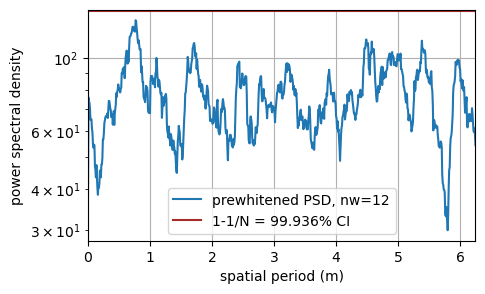

In [372]:
fig = plt.figure(figsize=(5,3))
ax = plt.axes()

ax.semilogy(f_res, S_est_res, label=f'prewhitened PSD, nw={nw}')
# conf2 = 0.999
conf2 = 1-1/len(y_4_lower)
# plt.axhline(spectral.white_psd_conf(conf1, sig2, dx, K=2*nw-1), 
#             label=f'{int(conf1*100):d}% CI')
ax.axhline(spectral.white_psd_conf(conf2, sig2, dx_dec, K=2*nw-1),
            label=f'1-1/N = {conf2*100:1.3f}% CI', color='brown')
# plt.loglog(f, ARMA_psd(f, phi, theta, sig2, dt=dx))
# plt.axvline(1/0.5)
# plt.axvline(1/0.25)

# ax.set_xticks([1/x for x in period_labels])
# ax.set_xticklabels(period_labels)
ax.set_xlim([np.min(f_res), np.max(f_res)])
ax.set_xlabel('spatial period (m)')
ax.set_ylabel('power spectral density')
# ax.set_title(f'spectrum from 1113 m to {cutoff_m} m in core')
# ax.set_title(f'spectrum from {cutoff_m} to 1370 m in core')

ax.grid()
# ax.set_ylim([25, 200])

plt.legend()

# plt.savefig('figures/Bao_reanalysis_uppercore_psd.pdf', format='pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figures/Bao_reanalysis_lowercore_psd.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

## Upper Unit 4

In [377]:
threshold_1 = 125
idx = (x_4_filt_dec > threshold_1)

n_spec = np.sum(idx)

x_4_upper = x_4_filt_dec[idx]
y_4_upper = signal.detrend(y_4_filt_dec[idx])

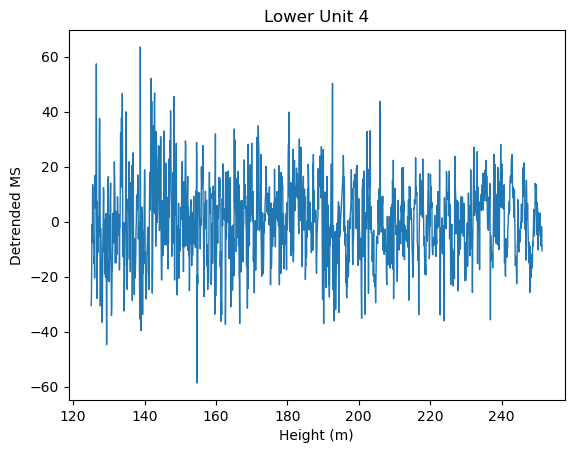

In [378]:
plt.plot(x_4_upper, y_4_upper, linewidth=1)

plt.xlabel('Height (m)')
plt.ylabel('Detrended MS')
plt.title('Lower Unit 4')

plt.show()

In [379]:
bao_fit = pm.auto_arima(y_4_upper, start_p=0, start_q=0,
                         max_p=15, max_q=15, seasonal=False,
                         d=None, trace=True,
                         error_action='ignore',  # don't want to know if an order does not work
                         suppress_warnings=True,  # don't want convergence warnings
                         stepwise=True, method='lbfgs', njobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12853.082, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12401.368, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12503.658, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12396.692, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12394.568, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=12394.642, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12391.273, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12396.437, Time=0.34 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=12393.256, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=12393.255, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12391.591, Time=0.47 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=12395.221, Time=0.61 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12393.270, Time=0.95 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 4.604 seconds


In [380]:
d = 0
arima_model = SARIMAX(y_4_upper, order=(3, d, 1))
bao_fit = arima_model.fit()

In [381]:
bao_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1580
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -6190.636
Date:                Wed, 06 Dec 2023   AIC                          12391.273
Time:                        15:26:09   BIC                          12418.098
Sample:                             0   HQIC                         12401.240
                               - 1580                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3040      0.136     -2.240      0.025      -0.570      -0.038
ar.L2          0.4018      0.070      5.769      0.000       0.265       0.538
ar.L3          0.0991      0.022      4.515      0.000       0.056       0.142
ma.L1          0.7733      0.135      5.745      0.000       0.509       1.037
sigma2       148.1406      3.683     40.224      0.000     140.922     155.359
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               544.37
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [382]:
ljungbox_p = spectral.LjungBox_p(bao_fit.resid, 3)
print(ljungbox_p)

0.005666999795887473


In [383]:
phi = bao_fit.arparams.reshape(-1, 1)
theta = bao_fit.maparams.reshape(-1, 1)
sig2 = bao_fit.params[-1]

p = len(phi)
q = len(theta)

In [384]:
nw = 12

S_est, f = spectral.multitaper(np.diff(y_4_upper, d), dx_dec, nw=nw)
S_est_res, f_res = spectral.multitaper(bao_fit.resid, dx_dec, nw=nw)

N = n_spec
w = nw/N
K = int(2 * nw - 1)

C:\Users\XPS\miniconda3\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


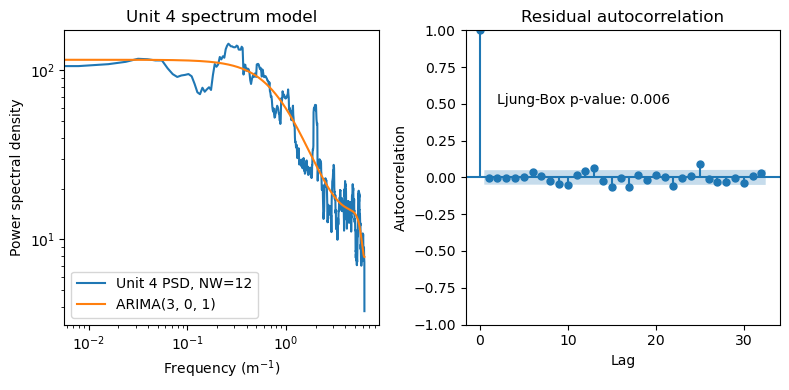

In [385]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].loglog(f, S_est, label=f'Unit 4 PSD, NW={nw}')
ax[0].loglog(f, 2*spectral.ARMA_psd(f, phi, theta, sig2, dt=dx_dec), label=f'ARIMA({p}, {d}, {q})')
ax[0].legend()
ax[0].set_xlabel('Frequency (m$^{-1}$)')
ax[0].set_ylabel('Power spectral density')
ax[0].set_title('Unit 4 spectrum model')

_ = pm.plot_acf(bao_fit.resid, ax=ax[1], alpha=0.05, title='Residual autocorrelation', show=False)
ax[1].text(2, 0.5, f'Ljung-Box p-value: {ljungbox_p:1.3f}')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')

plt.tight_layout()

# plt.savefig('figures/unit4_lower_spectrum_model.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [353]:
period_labels = [0.25, 0.5, 1, 2, 3, 4, 5, 10, 50]

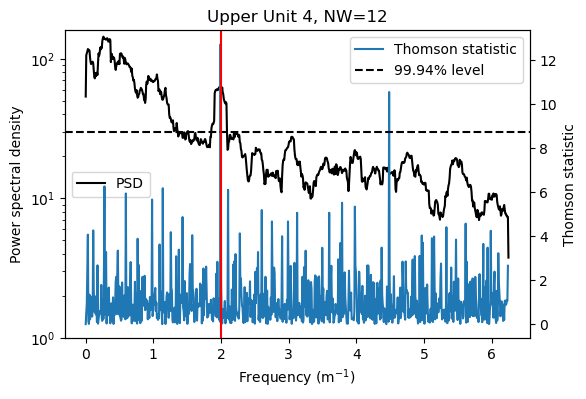

In [390]:
confs = [1-1/len(y_4_upper)]
F_stat, f_sig, levels = spectral.f_test_thom(y_4_upper, dx_dec, nw, confs=confs)

fig = plt.figure(figsize=(6,4))

ax1 = plt.axes()
ax1.semilogy(f, S_est, 'k-', label='PSD')
ax1.set_ylim([1, 160])
ax1.set_ylabel('Power spectral density')
ax1.set_xlabel('Frequency (m$^{-1}$)')
ax1.set_title(f'Upper Unit 4, NW={nw}')
ax1.legend(loc='center left')

ax2 = ax1.twinx()
ax2.plot(f_sig, F_stat, label='Thomson statistic')
for conf in confs:
    ax2.axhline(levels, color='k', linestyle='--', label=f'{100*conf:1.2f}% level')
ax2.set_ylabel('Thomson statistic')
ax2.legend()

# plt.savefig('figures/upper_unit4_psd.pdf', format='pdf', bbox_inches='tight')

plt.show()

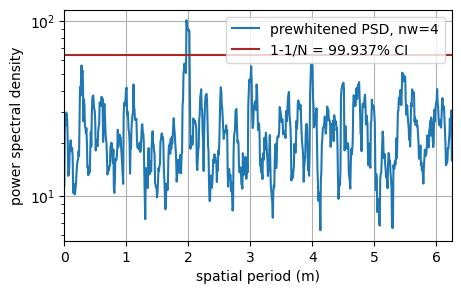

In [326]:
fig = plt.figure(figsize=(5,3))
ax = plt.axes()

ax.semilogy(f_res, S_est_res, label=f'prewhitened PSD, nw={nw}')
# conf2 = 0.999
conf2 = 1-1/len(y_4_upper)
# plt.axhline(spectral.white_psd_conf(conf1, sig2, dx, K=2*nw-1), 
#             label=f'{int(conf1*100):d}% CI')
ax.axhline(spectral.white_psd_conf(conf2, sig2, dx_dec, K=2*nw-1),
            label=f'1-1/N = {conf2*100:1.3f}% CI', color='brown')
# plt.loglog(f, ARMA_psd(f, phi, theta, sig2, dt=dx))
# plt.axvline(1/0.5)
# plt.axvline(1/0.25)

# ax.set_xticks([1/x for x in period_labels])
# ax.set_xticklabels(period_labels)
ax.set_xlim([np.min(f_res), np.max(f_res)])
ax.set_xlabel('spatial period (m)')
ax.set_ylabel('power spectral density')
# ax.set_title(f'spectrum from 1113 m to {cutoff_m} m in core')
# ax.set_title(f'spectrum from {cutoff_m} to 1370 m in core')

ax.grid()
# ax.set_ylim([25, 200])

plt.legend()

# plt.savefig('figures/Bao_reanalysis_uppercore_psd.pdf', format='pdf', bbox_inches='tight', dpi=300)
# plt.savefig('figures/Bao_reanalysis_lowercore_psd.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [52]:
from statsmodels.tsa.arima.model import ARIMA

In [60]:
arima = ARIMA(y_4, order=(p, 0, 0))
res = arima.fit()
# arima.fit
# ARIMA.fit(y_4

As visible in the power spectral density estimate above, the upper 150 m of the core (from approximately 1115 to 1250 m) exhibits significant periodicity at two spatial periods: 0.5 and 0.2 m. 

In the paper, the authors do not extend the frequency axis to permit visualization of the high frequency 0.2 m peak. In their interpretation, the 0.5 m peak corresponds to precession, which would imply that the 0.2 m peak corresponds to semi-precession. However, semi-precession is only a relevant orbital forcing at extremely low, near equatorial latitudes. Given that the paleogeography of South China Block suggests it was at mid-latitudes during the Cryogenian (Zhang et al., 2015), the presence of semi-precession is unlikely.

> Zhang, S., Li, H., Jiang, G., Evans, D.A.D., Dong, J., Wu, H., Yang, T., Liu, P., and Xiao, Q., 2015, New paleomagnetic results from the Ediacaran Doushantuo Formation in South China and their paleogeographic implications: Precambrian Research, v. 259, p. 130–142, doi:10.1016/j.precamres.2014.09.018.
